# Tensorboard 可视化（Tensorboard visualization）

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 预处理数据

In [2]:
# 导入torchvision库
import torchvision
from torchvision import datasets, transforms
# 定义一个转换函数，将图像转换为张量（Tensor）
transformation = transforms.Compose([
                                transforms.ToTensor(),  # transforms.ToTensor()会将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
                                # transforms.Normalize((0.5,), (0.5,))  # transforms.Normalize()会将图像的像素值进行标准化，即将像素值减去均值，然后除以标准差
])

# 从datasets模块中导入MNIST数据集
# 训练集
train_ds = datasets.MNIST(
                          # 数据集的存储路径
                          'dataset/',
                          # 是否为训练集
                          train=True,
                          # 数据集的转换函数
                          transform=transformation,
                          # 是否下载数据集
                          download=True  
)
# 测试集
test_ds = datasets.MNIST(
                          'dataset/',
                          train=False,
                          transform=transformation,
                          download=True  
)

In [3]:
# 创建dataloader对象，用于批量加载数据集
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True) # 对dataset进行封装，将数据批量加载，batch_size为64，shuffle为True表示打乱数据集
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64)

## 熟悉数据集

torch.Size([64, 1, 28, 28])
torch.Size([1, 28, 28])
(28, 28)
tensor(1)


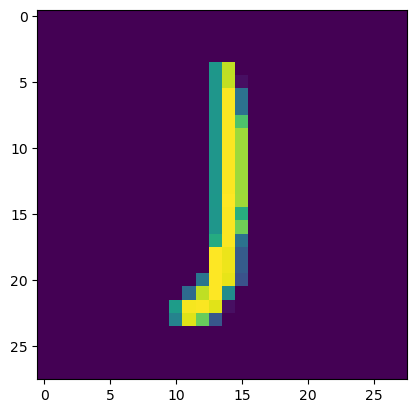

In [4]:
# iter()函数可以将一个可迭代对象转换为一个迭代器
# next()函数可以从迭代器中获取一个批次的数据
imgs, labels = next(iter(train_dl))
# 在pytorch里面图片的表示形式：【batch， channel， hight， width】
# transforms.ToTensor()将图像转换为张量，并且将像素值缩放到0-1之间，并且将channel放在第一维度上
print(imgs.shape) # [batch, channel, hight, width]
img = imgs[0] # 切片取出一张图片
print(img.shape) # [channel, hight, width]
img = img.numpy() # 将张量转换为numpy数组(ndarray)
img = np.squeeze(img) # 将张量中的维度为1的维度去掉
print(img.shape) # [hight, width]
print(labels[0]) # 打印出图片对应的标签
plt.imshow(img)  # 显示图片

tensor([1, 3, 7, 0, 6, 4, 7, 0, 5, 6])


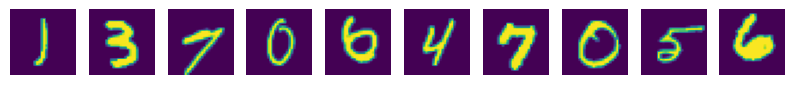

In [5]:
print(labels[:10]) # 打印出前10张图片对应的标签
# 图片显示函数
def imshow(img):
    npimg = img.numpy()
    npimg = np.squeeze(npimg)
    plt.imshow(npimg)
plt.figure(figsize=(10, 1)) # 创建一个figure画布对象，设置大小为10*1
# 遍历imgs中的前10张图片
for i, img in enumerate(imgs[:10]):
    plt.subplot(1, 10, i+1) # 绘制子图，设置子图的行数为1，列数为10，第i+1个子图
    plt.axis('off') # 关闭坐标轴
    imshow(img)

## 导入 Tensorboard

**Tensorboard可视化步骤：**
1. 在代码中将需要可视化的数据写入磁盘，例如训练过程中的损失函数值、准确率等。
2. 在命令行中启动Tensorboard，指定日志文件所在的目录。`tensorboard --logdir=logs --port=6006`
3. 在浏览器中打开Tensorboard，查看训练过程中的数据可视化结果。

In [6]:
# 导入Tensorboard库，SummaryWriter类用于记录训练过程中的数据
from torch.utils.tensorboard import SummaryWriter

# 创建一个SummaryWriter对象，用于记录训练过程中的数据，指定保存到logs文件夹中
writer = SummaryWriter('./logs/mnist')

### 在 Tensorboard 中显示图片

In [7]:
# 获取train_dl中一个批次的数据
images, labels = next(iter(train_dl))

# 使用torchvision.utils.make_grid()函数将多张图片转换为网格形式
img_grid = torchvision.utils.make_grid(images[:8])

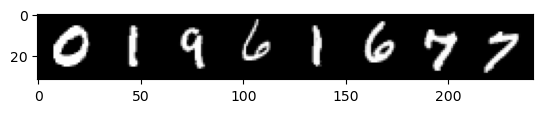

In [8]:
# 使用matplotlib显示图片
np_img = img_grid.permute(1, 2, 0).numpy()
plt.imshow(np_img)

In [9]:
# 在Tensorboard中显示图片
writer.add_image(tag='eight_mnist_images', img_tensor=img_grid)

在 Tensorboard 中显示图片，在命令行中启动 Tensorboard，指定日志文件所在的目录。`tensorboard --logdir=./logs/mnist --port=6006`

### 动态显示

In [10]:
# 动态地显示后八张图片
img_grid_last = torchvision.utils.make_grid(images[-8:])
writer.add_image('eight_mnist_images_last', img_grid_last)

## 创建模型

In [11]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0) # 卷积层，输入通道数为1，输出通道数为6，卷积核大小为5，步长为1，填充为0
        self.pool = nn.MaxPool2d(kernel_size=(2, 2)) # 池化层，池化核大小为2
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0) # 卷积层，输入通道数为6，输出通道数为16，卷积核大小为5，步长为1，填充为0
        self.liner_1 = nn.Linear(16 * 4 * 4, 256)    # 输入层到隐藏层，全连接层，超参数选择为256
        self.liner_2 = nn.Linear(256, 10)       # 隐藏层到输出层，分类数为10
    def forward(self, input):
        x = F.relu(self.conv1(input))           # 第一层卷积，激活函数为ReLU
        x = self.pool(x)                        # 池化层
        x = F.relu(self.conv2(x))               # 第二层卷积，激活函数为ReLU
        x = self.pool(x)                        # 池化层
        # print(x.shape) # [batch, channel, hight, width]   [64, 16, 4, 4]
        x = x.view(x.size(0), -1)           # 将输入的图片展平，将channel维度去掉，将hight和width维度合并为一个维度 16 * 4 * 4
        x = F.relu(self.liner_1(x))             # 第一层，激活函数为ReLU
        logits = self.liner_2(x)                # 输出层，不使用激活函数，未激活的输出通常被称为logits
        return logits

## 训练参数准备

In [12]:
# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model = Model().to(device) # 将模型移动到GPU上实例化模型

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.SGD(model.parameters(), lr=0.001) # 优化器，SGD优化器，学习率为0.001
epochs = 20

### 可视化模型

In [13]:
# 在 Tensorboard 中显示模型结构
writer.add_graph(model=model, input_to_model=images.to(device))
# 打印模型结构
model

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (liner_1): Linear(in_features=256, out_features=256, bias=True)
  (liner_2): Linear(in_features=256, out_features=10, bias=True)
)

### 动态显示训练过程中的loss 和 acc的变化

## 模型训练

In [14]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化，使用tensorboard记录训练过程中的数据
# 训练函数
def train(train_dl, model, loss_fn, opt):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    train_loss /= num_batches # 计算平均损失
    train_acc /= size # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt, writer):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt)
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        writer.add_scalar(tag='train_loss', scalar_value=epoch_train_loss, global_step=epoch) # 在 Tensorboard 中记录训练集损失
        writer.add_scalar(tag='train_acc', scalar_value=epoch_train_acc, global_step=epoch) # 在 Tensorboard 中记录训练集准确率
        writer.add_scalar(tag='test_loss', scalar_value=epoch_test_loss, global_step=epoch) # 在 Tensorboard 中记录测试集损失
        writer.add_scalar(tag='test_acc', scalar_value=epoch_test_acc, global_step=epoch) # 在 Tensorboard 中记录测试集准确率

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt, writer)


Epoch: 0, Train Loss: 2.3006, Train Acc: 12.52%, Test Loss: 2.2948, Test Acc: 13.42%
Epoch: 1, Train Loss: 2.2879, Train Acc: 18.73%, Test Loss: 2.2780, Test Acc: 26.54%
Epoch: 2, Train Loss: 2.2617, Train Acc: 33.71%, Test Loss: 2.2359, Test Acc: 41.98%
Epoch: 3, Train Loss: 2.1752, Train Acc: 50.79%, Test Loss: 2.0643, Test Acc: 64.13%
Epoch: 4, Train Loss: 1.7341, Train Acc: 66.10%, Test Loss: 1.2426, Test Acc: 73.61%
Epoch: 5, Train Loss: 0.9215, Train Acc: 76.55%, Test Loss: 0.6803, Test Acc: 80.66%
Epoch: 6, Train Loss: 0.6216, Train Acc: 81.86%, Test Loss: 0.5363, Test Acc: 83.86%
Epoch: 7, Train Loss: 0.5205, Train Acc: 84.57%, Test Loss: 0.4677, Test Acc: 85.87%
Epoch: 8, Train Loss: 0.4642, Train Acc: 86.21%, Test Loss: 0.4181, Test Acc: 87.68%
Epoch: 9, Train Loss: 0.4238, Train Acc: 87.41%, Test Loss: 0.3889, Test Acc: 88.28%
Epoch: 10, Train Loss: 0.3921, Train Acc: 88.37%, Test Loss: 0.3580, Test Acc: 89.43%
Epoch: 11, Train Loss: 0.3660, Train Acc: 89.12%, Test Loss: 0.3

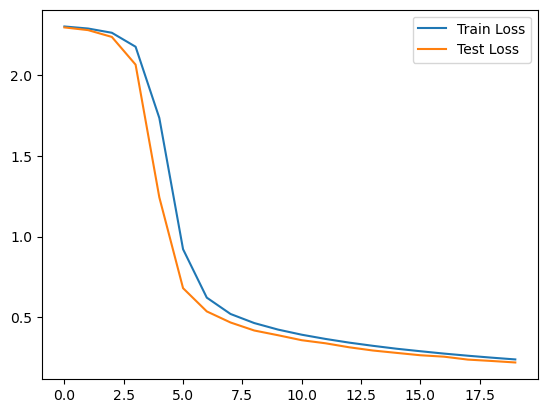

In [15]:
plt.plot(range(epochs), train_loss, label='Train Loss')
plt.plot(range(epochs), test_loss, label='Test Loss')
plt.legend()

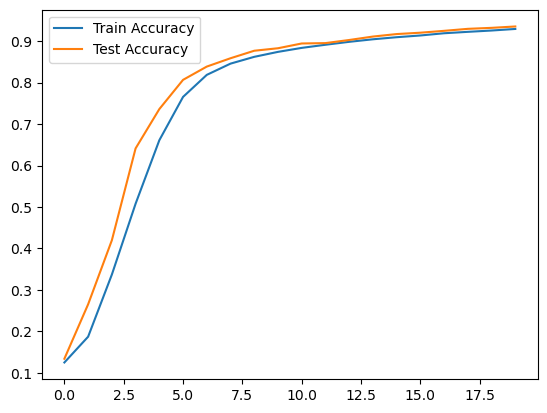

In [16]:
plt.plot(range(epochs), train_acc, label='Train Accuracy')
plt.plot(range(epochs), test_acc, label='Test Accuracy')
plt.legend()